# Telco Customer Churn — End-to-End Notebook
Run top-to-bottom. SHAP is optional and auto-skips.

## 1) Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

import joblib


## 2) Load data

In [2]:
PROJECT_ROOT = Path.cwd()
if (PROJECT_ROOT / "notebooks").exists():
    pass
elif (PROJECT_ROOT.parent / "notebooks").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

CSV_PATH = PROJECT_ROOT / "data" / "raw" / "WA_Fn-UseC_-Telco-Customer-Churn.csv"
print("CSV path:", CSV_PATH)
print("Exists:", CSV_PATH.exists())

if not CSV_PATH.exists():
    import kagglehub
    downloaded = Path(kagglehub.dataset_download("blastchar/telco-customer-churn"))
    src = list(downloaded.rglob("WA_Fn-UseC_-Telco-Customer-Churn.csv"))[0]
    CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
    CSV_PATH.write_bytes(src.read_bytes())
    print("Downloaded to:", CSV_PATH)

df = pd.read_csv(CSV_PATH)
df.head()


CSV path: C:\Users\reddy\Downloads\telco-churn-retention-v3\telco-churn-retention-v3\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv
Exists: True


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3) Clean + target

In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).copy()

df["ChurnFlag"] = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)
y = df["ChurnFlag"].astype(int)
X = df.drop(columns=["Churn", "ChurnFlag"])

if "customerID" in X.columns:
    X = X.drop(columns=["customerID"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])


## 4) Train + evaluate (Logistic Regression)

CV ROC-AUC mean: 0.8460590993383919
Test ROC-AUC: 0.8359290473207676
Test PR-AUC: 0.6228170767081351
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



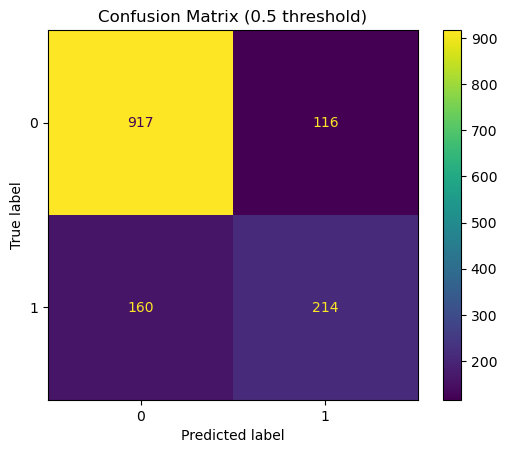

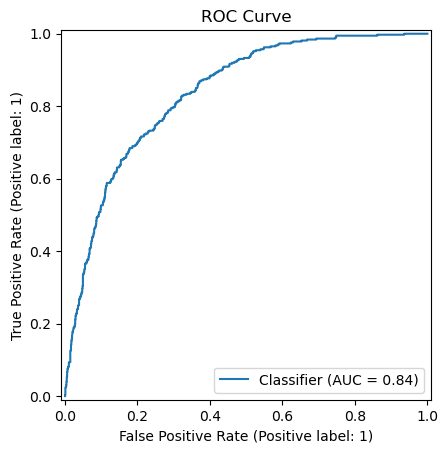

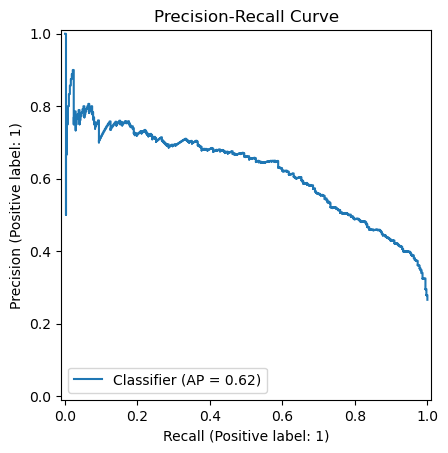

In [6]:
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", __import__("sklearn.preprocessing").preprocessing.StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])

clf = Pipeline([("prep", preprocessor), ("model", LogisticRegression(max_iter=5000))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
print("CV ROC-AUC mean:", cv_auc.mean())

clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
pred = (probs >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, probs))
print("Test PR-AUC:", average_precision_score(y_test, probs))
print(classification_report(y_test, pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
plt.title("Confusion Matrix (0.5 threshold)")
plt.show()

RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title("Precision-Recall Curve")
plt.show()


## 5) Interpretability

In [7]:
prep = clf.named_steps["prep"]
model = clf.named_steps["model"]

ohe = prep.named_transformers_["cat"].named_steps["onehot"]
feature_names = num_cols + ohe.get_feature_names_out(cat_cols).tolist()

coef_df = pd.DataFrame({"feature": feature_names, "coef": model.coef_.ravel()})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(20)


,feature,coef,abs_coef
1,tenure,-1.352313,1.352313
38,Contract_Two year,-0.779030,0.779030
3,TotalCharges,0.644014,0.644014
15,InternetService_DSL,-0.616132,0.616132
36,Contract_Month-to-month,0.613846,0.613846
16,InternetService_Fiber optic,0.590184,0.590184
2,MonthlyCharges,-0.541006,0.541006
39,PaperlessBilling_No,-0.300387,0.300387
12,MultipleLines_No,-0.293470,0.293470
22,OnlineBackup_No internet service,-0.283724,0.283724


In [8]:
perm = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, scoring="roc_auc")
perm_df = pd.DataFrame({"feature": X_test.columns, "importance_mean": perm.importances_mean})
perm_df.sort_values("importance_mean", ascending=False).head(20)


,feature,importance_mean
4,tenure,0.195545
7,InternetService,0.045463
14,Contract,0.036450
18,TotalCharges,0.022212
17,MonthlyCharges,0.021145
15,PaperlessBilling,0.004585
12,StreamingTV,0.004231
11,TechSupport,0.004092
13,StreamingMovies,0.003541
8,OnlineSecurity,0.003187


## 6) Optional SHAP

In [9]:
try:
    import shap
    X_t = clf.named_steps["prep"].transform(X_test)
    X_shap = X_t.toarray() if hasattr(X_t, "toarray") else X_t
    explainer = shap.LinearExplainer(model, X_shap, feature_names=feature_names)
    sv = explainer(X_shap)
    shap.plots.beeswarm(sv, max_display=20)
except Exception as e:
    print("SHAP skipped:", repr(e))


SHAP skipped: ModuleNotFoundError("No module named 'shap'")


## 7) Save model artifact

In [10]:
REPORTS = PROJECT_ROOT / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)
out = REPORTS / "churn_model_logreg.joblib"
joblib.dump(clf, out)
print("Saved:", out)


Saved: C:\Users\reddy\Downloads\telco-churn-retention-v3\telco-churn-retention-v3\reports\churn_model_logreg.joblib


## 8) Load Saved Model

In [14]:
loaded_model = joblib.load(out)

sample = X_test.iloc[[0]].copy()
prob = loaded_model.predict_proba(sample)[:, 1][0]

print("Loaded model path:", out)
print("Sample churn probability (loaded model):", prob)
display(sample)

Loaded model path: C:\Users\reddy\Downloads\telco-churn-retention-v3\telco-churn-retention-v3\reports\churn_model_logreg.joblib
Sample churn probability (loaded model): 0.01751302767619668


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
974,Female,0,Yes,Yes,59,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),75.95,4542.35
